# **FC-LSTM with No PCA:**

***

LSTM without PCA performed significantly worse than the one with PCA. 

This is why FC-LSTM with PCA is in our main submission. 

For more details and code look into FC_LSTM_predict_on_real_data.ipynb for further details about surprise storm results.

For the performance on the competition data, check : FC_LSTM_predict.ipynb

Both files are in the backup folder.

Here are the results:

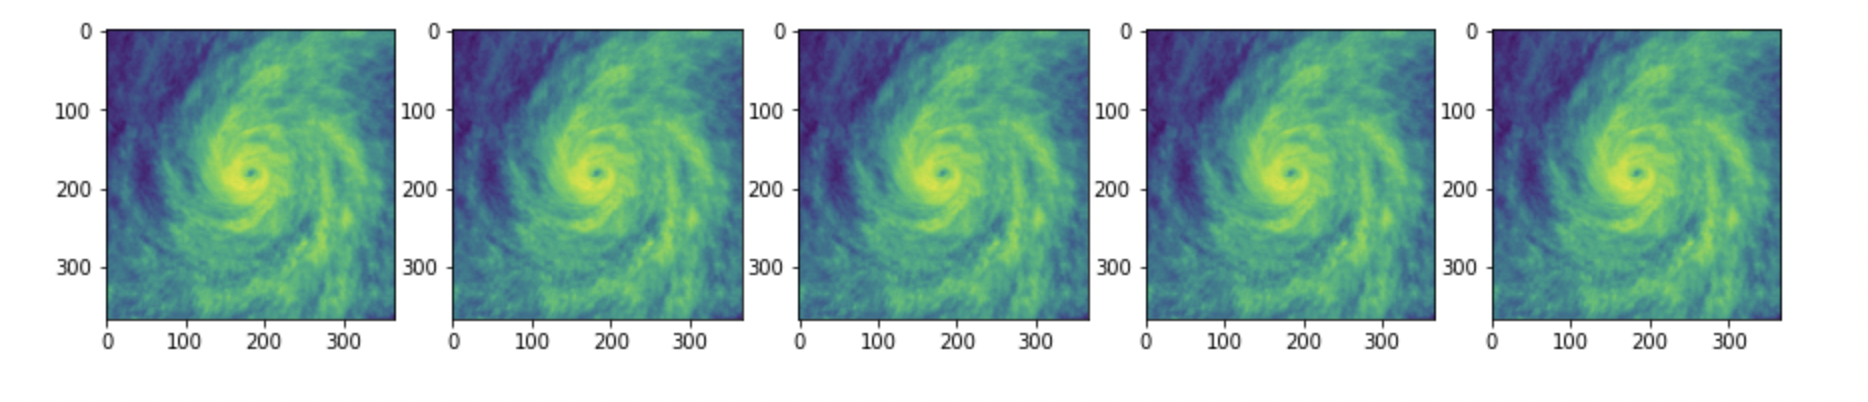

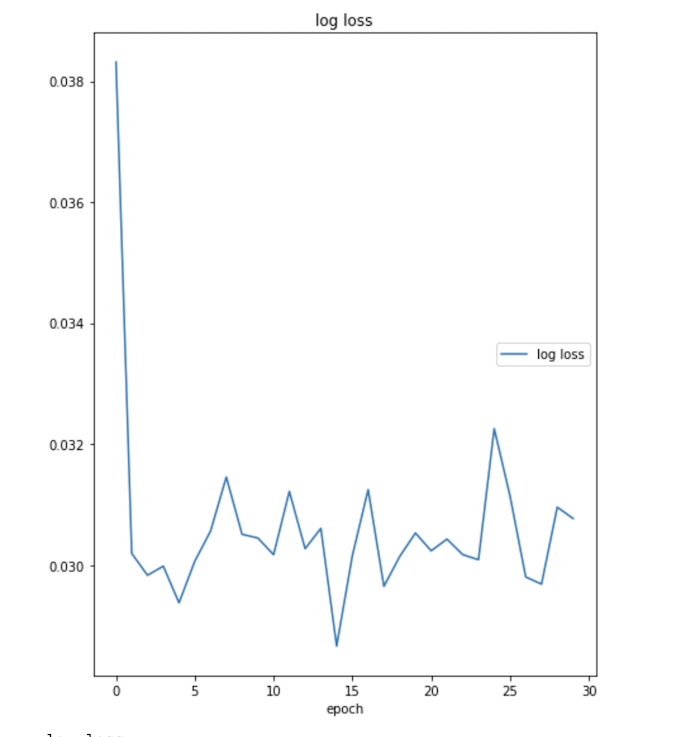

#**Motivation for ConvLSTM**

***

At the beginning of the week, once we knew we were supposed to be doing spatio-temporal predictions, we began searching online for the best methods to do so.

We came across a paper titled ["Sequential Images Prediction Using Convolutional LSTM with Application in Precipitation Nowcasting"](https://prism.ucalgary.ca/bitstream/handle/1880/110862/ucalgary_2019_wu_mingkuan.pdf?sequence=2). In this paper, the author explains in a very clear way what are suitable methods to employ for a problem such as ours.
The two main methods discussed are: **FC-LSTM** and **Conv-LSTM**. 

The paper pinpointed key advantages that **Conv-LSTM** networks have: they are able to preserve spatial relationships of the pixels in the images due to the convolutional layer. 

Therefore, we decided to give **Conv-LSTM** networks a try.

#**Download Packages**

***

In [63]:
! pip install livelossplot
! pip install pycm
! pip install pandas_path
! pip install radiant-mlhub
! mlhub configure
# 35361fda09194c44246f4d14b3c77d68868a9e58d93f83803c6ee88b80faf441

#**Import Packages and Set Device**

***

In [3]:
import os
import tarfile
import numpy as np
import random
import json
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset 
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from radiant_mlhub import Dataset
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from radiant_mlhub import Dataset, Collection, client
from glob import glob
from pycm import *
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image as pil_image
import sys



os.environ['MLHUB_API_KEY'] = '35361fda09194c44246f4d14b3c77d68868a9e58d93f83803c6ee88b80faf441'

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


#**Conv-LSTM Version 1: Train Model on 20 Storms**

***

##**Fetch Data and Prepare for Training**
***

##**Download Training and Testing Datasets**

In [64]:
# Download the train-test datasets
dataset = Dataset.fetch('nasa_tropical_storm_competition')
dataset.download(output_dir='.')

# Unzip the dataset
for path, directories, files in os.walk('./'):
    for f in files:
        if f.endswith(".tar.gz"):
            tar = tarfile.open(os.path.join(path,f), 'r:gz')
            tar.extractall(path=path)
            tar.close()


In [4]:
# Convert training data into a dataframe

train_data = []

train_source = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'

download_dir = Path('./')

jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)


    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']),
        int(labels_data['wind_speed'])
    ])
train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean','Wind Speed']
).sort_values(by=['Image ID']).reset_index(drop=True)

In [5]:
# Convert testing data into a dataframe
test_data = []
test_source = 'nasa_tropical_storm_competition_test_source'
test_labels = 'nasa_tropical_storm_competition_test_labels'
jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(test_source, test_labels)
  
    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed'])
    ])

test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean','Wind Speed']
).sort_values(by=['Image ID']).reset_index(drop=True)

test_df = test_df.sort_values(by='Relative Time')

##**Combine All Storms and Visualize Some of the Results**

In [6]:
# Combine Training and Testing Data
data = train_df.append(test_df)

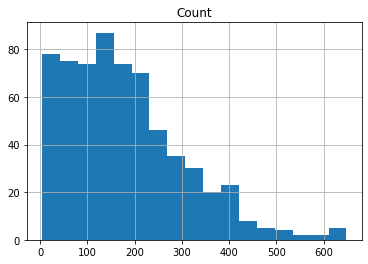

In [8]:
# Check how many image we have for each storm by creating "df" dataframe
df = data.groupby(['Storm ID']).size().reset_index(name='Count')
df.sort_values(by=['Count'])
df = df.reset_index(drop=True)
hist = df.hist(bins='auto')

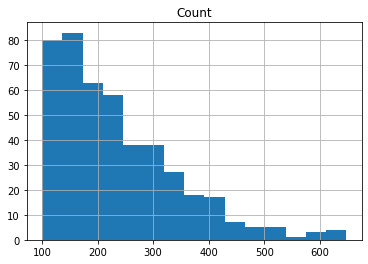

In [9]:
#remove all storms with image count less than 100
df = df.drop(df[df.Count < 100].index)
data = data[data['Storm ID'].isin(df['Storm ID'])]
df = df.reset_index(drop=True)
hist = df.hist(bins='auto')

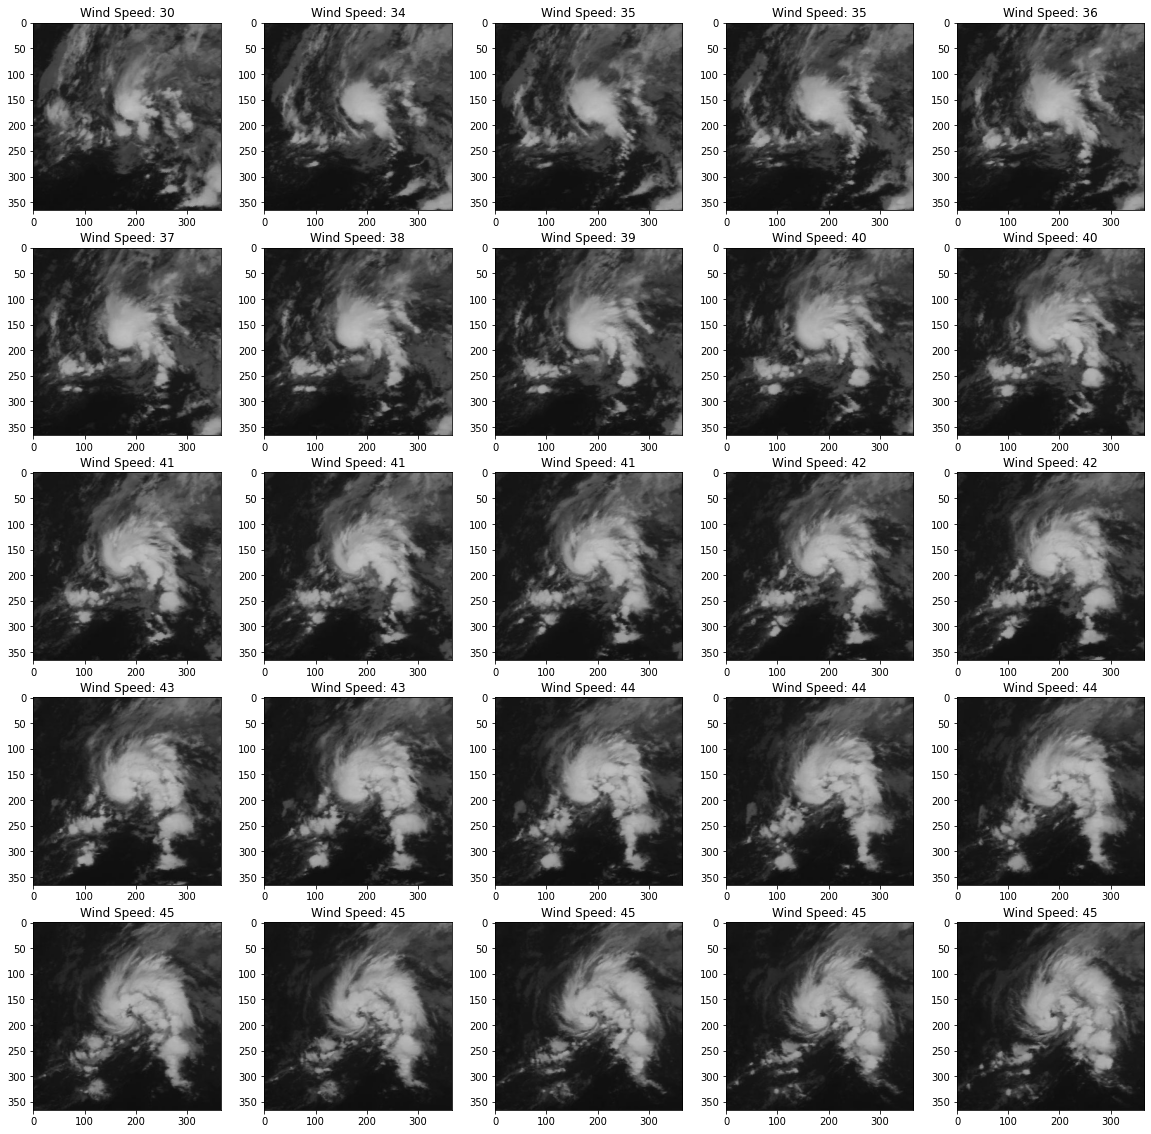

In [10]:
# visualize a sample storm
example_storm = data.loc[data['Storm ID'] == df['Storm ID'][10]]
fig, axs = plt.subplots(5, 5, figsize=(20, 20),squeeze=False)

for i in range(5):
  for j in range(5):
    try:
      image = pil_image.open('/content/nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_'+str(example_storm.iloc[i*5+j]['Image ID'])+"/image.jpg").convert("RGB")
    except FileNotFoundError:
      image = pil_image.open('/content/nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_'+str(example_storm.iloc[i*5+j]['Image ID'])+"/image.jpg").convert("RGB")
    axs[i][j].set_title("Wind Speed: "+ example_storm.iloc[i*5+j]['Wind Speed'])
    axs[i][j].imshow(image)

##**Split Data into Training and Validation Sets**

In [11]:
# Create a row_indcs array that finds out where the images of each storm start
row_indcs = np.zeros(len(df))
row_indcs[0] = 0.0
for i in range(len(df['Count'])-1):
  row_indcs[i+1] = df['Count'][i] + row_indcs[i]

import random
random.shuffle(row_indcs)

In [112]:
# Create the training and validation arrays to pass to our model
transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize([366,366]),
                transforms.Grayscale()
                
            ]
        )

# use 20random arrays for training
train_tensor = np.empty((20,30,366,366),dtype="float32")
for i in range(20):
  start = row_indcs[i+1]
  for j in range(30):
    try:
      image = pil_image.open('/content/nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_'+str(data.iloc[int(start+j)]['Image ID'])+"/image.jpg").convert("RGB")
    except FileNotFoundError:
      image = pil_image.open('/content/nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_'+str(data.iloc[int(start+j)]['Image ID'])+"/image.jpg").convert("RGB")
    image = transform(image)
    # print(image)
    train_tensor[i][j] = image

# use 8 arrays for validation
val_tensor = np.empty([8,30,366,366],dtype='float32')
for i in range(8):
  start = row_indcs[i+1+60]
  for j in range(20):
    try:
      image = pil_image.open('/content/nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_'+str(data.iloc[int(start+j)]['Image ID'])+"/image.jpg").convert("RGB")
    except FileNotFoundError:
      image = pil_image.open('/content/nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_'+str(data.iloc[int(start+j)]['Image ID'])+"/image.jpg").convert("RGB")
    image = transform(image)
    val_tensor[i][j] = image


##**Perform a Hyperparameter Grid-search on Learning Rate and Number of Epochs**
***

In [109]:
def collate(batch):
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch.to(device)                     
    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,30)                     
    return batch[:,:,rand-6:rand], batch[:,:,rand]   


In [179]:
def collate_test(batch):

    # Last 5 frames are target
    target = np.array(batch)[:,95:]                    
    
    # Add channel dim send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    # batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

In [125]:
import sys
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/My Drive')
from convLSTM import net_convLSTM
from torch.optim import Adam

Mounted at /content/gdrive


In [16]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for batch_num, (input, target) in enumerate(data_loader, 1): 
        output = model(input)
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optimizer.step() 
        optimizer.zero_grad()                                           
        train_loss += loss.item()
    train_loss /= len(data_loader.dataset) 
        
    return train_loss

In [17]:
def validate(model, optimizer, criterion, data_loader):
  val_loss = 0 
  model.eval()
  with torch.no_grad():                                          
      for input, target in data_loader:                          
          output = model(input)                                   
          loss = criterion(output.flatten(), target.flatten())   
          val_loss += loss.item()                                
  val_loss /= len(data_loader.dataset)  
  return val_loss  

In [113]:
def train_model(learning_rate, epochs):
  model = net_convLSTM(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(366,366), num_layers=2).to(device)
  optimizer = Adam(model.parameters(), lr=1e-4)
  criterion = nn.MSELoss()
  
  train_loader = DataLoader(train_tensor, shuffle=True, 
                          batch_size=2, collate_fn=collate)

  val_loader = DataLoader(val_tensor, shuffle=True, 
                          batch_size=2, collate_fn=collate)

  for epoch in range(epochs):
      train_loss = train(model, optimizer, criterion, train_loader)
      val_loss = validate(model, optimizer, criterion, val_loader)
      # print(train_loss,validation_loss)
  return model, train_loss, val_loss

In [ ]:
torch.cuda.empty_cache()

In [114]:
def grid_search(lr_list, epochs_list):
  """Perform a grid-search to find the best learning rate and number of epochs.

  Args:
      lr_list: list of learning rates.
      epochs_list: list of number of epochs.
  Returns:
      train_res: array of train losses.
      val_res: array of train losses.
  """
  val_results = np.empty((len(lr_list),len(epochs_list)),dtype='float32')
  train_results = np.empty((len(lr_list),len(epochs_list)),dtype='float32')
  for lr_idx in range(len(lr_list)):
      lr = lr_list[lr_idx]
      for epochs_idx in range(len(epochs_list)):
        epochs = epochs_list[epochs_idx]
        print(lr, epochs)
        model, train_loss, val_loss = train_model(lr, epochs)
        val_results[lr_idx][epochs_idx] = val_loss
        train_results[lr_idx][epochs_idx] = train_loss
  return train_results, val_results


In [115]:
epochs_list = [3,7]
lr_list = [1e-3,1e-4]
train_res, val_res = grid_search(lr_list, epochs_list)

0.001 3
0.001 7
0.0001 3
0.0001 7


In [117]:
train_res

array([[0.02281083, 0.01718543],
       [0.02403981, 0.01930213]], dtype=float32)

In [118]:
val_res

array([[6.07658923e-02, 1.13273125e+02],
       [6.66097105e-02, 9.94562683e+01]], dtype=float32)

##**Train Using Best Hyperparameters**
***

###Combine Training and Validation Sets

In [65]:
random.shuffle(row_indcs)
train_tensor = np.empty((20,30,366,366),dtype="float32")
for i in range(20):
  start = row_indcs[i+1]
  for j in range(30):
    try:
      image = pil_image.open('/content/nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_'+str(data.iloc[int(start+j)]['Image ID'])+"/image.jpg").convert("RGB")
    except FileNotFoundError:
      image = pil_image.open('/content/nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_'+str(data.iloc[int(start+j)]['Image ID'])+"/image.jpg").convert("RGB")
    image = transform(image)
    # print(image)
    train_tensor[i][j] = image


###Train Using Best Hyperparameters

In [218]:
model = net_convLSTM(num_channels=1, num_kernels=64, 
  kernel_size=(3,3), padding=(1, 1), activation="relu", 
  frame_size=(366,366), num_layers=2).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_loader = DataLoader(train_tensor, shuffle=True, 
                          batch_size=2, collate_fn=collate)
# validation_loader = DataLoader(validate_data, batch_size=1000, shuffle=False, num_workers=0)
logs = {"trainloss":''}
for epoch in range(3):
    train_loss = train(model, optimizer, criterion, train_loader)
    logs['trainloss'] = train_loss


##**Predict Using Model Trained on 20 Random Storms**
***

### Load Surprise Storm

In [66]:
test_data = []

test_source = 'nasa_tropical_storm_competition_surprise_storm_source'
test_labels = 'nasa_tropical_storm_competition_surprise_storm_labels'
jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(test_source, test_labels)
  
    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed'])
    ])

test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean','Wind Speed']
).sort_values(by=['Image ID']).reset_index(drop=True)

test_df = test_df.sort_values(by='Relative Time')

surprise_test_tensor = np.empty((1,100,366,366),dtype="float32")

for j in range(100):
  image = pil_image.open('/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_'+str(test_df.iloc[j]['Image ID'])+"/image.jpg").convert("RGB")
  image = transform(image)
  surprise_test_tensor[0][j] = image

test_loader = DataLoader(surprise_test_tensor, shuffle=False, 
                        batch_size=1, collate_fn=collate_test)

torch.Size([1, 1, 10, 366, 366])
torch.Size([1, 1, 10, 366, 366])
torch.Size([1, 1, 10, 366, 366])
torch.Size([1, 1, 10, 366, 366])
torch.Size([1, 1, 10, 366, 366])


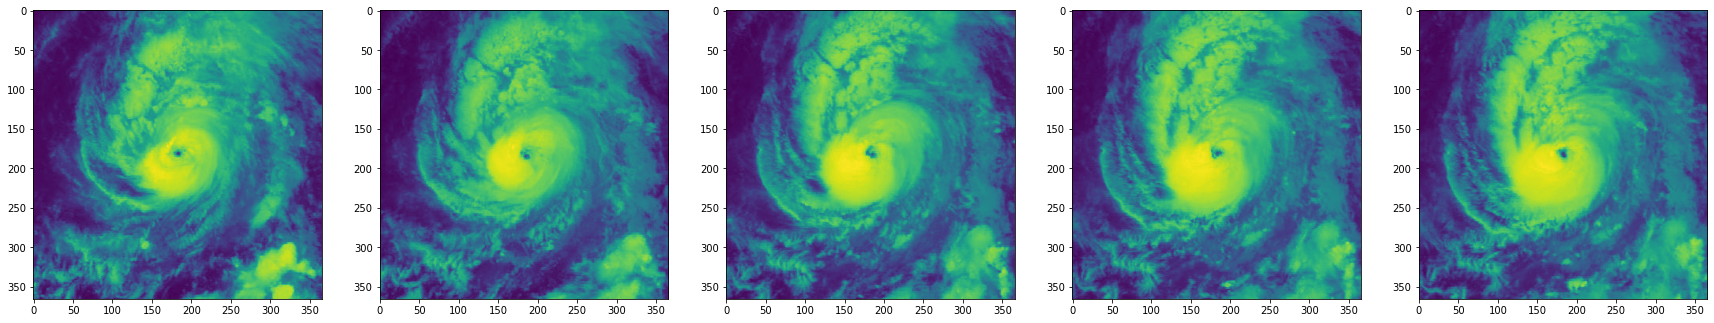

In [219]:
import matplotlib.pyplot as plt
batch, target = next(iter(test_loader))

output = np.zeros(target.shape)

for timestep in range(target.shape[1]):
  input = batch[:,:,85:95]
  print(input.shape)   
  output[:,timestep]=(model(input).squeeze(1).cpu().detach().numpy())*255

fig, axs = plt.subplots(1, 5, figsize=(30, 30),squeeze=False)
axs[0][0].imshow(target[0][0])
axs[0][1].imshow(target[0][1])
axs[0][2].imshow(target[0][2])
axs[0][3].imshow(target[0][3])
axs[0][4].imshow(target[0][4])

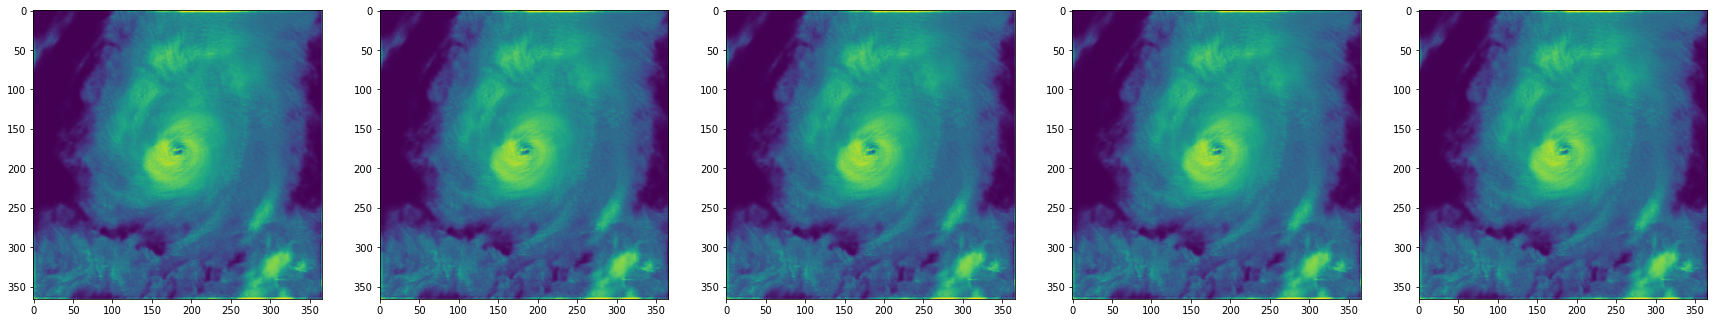

In [221]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

for i in range(5):
  vmse = mse(output[0][i],target[0][i])
  vssim = ssim(output[0][i],target[0][i])
  print('mse:',vmse,"ssim:",vssim)

mse: 9767.071988943622 ssim: 0.02024366571657528
mse: 9765.696574785536 ssim: 0.020896830582378973
mse: 9765.223409860308 ssim: 0.020421193025616798
mse: 9765.179603399694 ssim: 0.02042196357554033
mse: 9764.778384828498 ssim: 0.020307589875792578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  


# **Conv-LSTM Version 2: Train using the Surprise Storm**

This part is essentially the same as the one above except for 2 main differences:


*   we train using the surprise storm (first 95 images)
*   we use images by 3s, we read 3 and predict the one after then append it to the images, and continue predicting. (which we don't do above)



In [49]:
# load the dataset
train_data = []
train_source = 'nasa_tropical_storm_competition_surprise_storm_source'
train_labels = 'nasa_tropical_storm_competition_surprise_storm_labels'
download_dir = Path('./')
jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)
    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed'])
    ])

train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed']
).sort_values(by=['Relative Time']).reset_index(drop=True)

train_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed
0,sss_001,sss,437401,1,120
1,sss_002,sss,439200,1,121
2,sss_003,sss,442800,1,124
3,sss_004,sss,448200,1,128
4,sss_005,sss,453600,1,130


In [50]:
train_df["Path"] = (
  "./nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_" + train_df['Image ID']+'/image.jpg'
)

train_df['Path']

0     ./nasa_tropical_storm_competition_surprise_sto...
1     ./nasa_tropical_storm_competition_surprise_sto...
2     ./nasa_tropical_storm_competition_surprise_sto...
3     ./nasa_tropical_storm_competition_surprise_sto...
4     ./nasa_tropical_storm_competition_surprise_sto...
                            ...                        
95    ./nasa_tropical_storm_competition_surprise_sto...
96    ./nasa_tropical_storm_competition_surprise_sto...
97    ./nasa_tropical_storm_competition_surprise_sto...
98    ./nasa_tropical_storm_competition_surprise_sto...
99    ./nasa_tropical_storm_competition_surprise_sto...
Name: Path, Length: 100, dtype: object

In [53]:
def get_data(train_df, storm_lst, num_sample_per_strom =100 ,
                     num_of_storm = 5, image_size =64 ): 
  '''
  This function returns an array for the stroms' images' data

  Inputs
  ------
  train_df (pd.Dataframe): dataframe for the data 
  storm_lst (list): list to choose the storm 
  num_sample_per_storm (int): number of samples for each storm
  num_of_storm (int): number of storms to be selected from the list 
  image_size (int): size of the images to be transformed to 

  Returns
  ------
  Return an array for the number of storms, each with a number of samples 
  '''            

  transform = transforms.Compose([
        transforms.Grayscale(),# convert the images to grayscale
        transforms.Resize(image_size), 
    ])
  
  curr_df = train_df[train_df['Storm ID'].isin(storm_lst[0: num_of_storm])].groupby('Storm ID').head(num_sample_per_strom)
  curr_df = curr_df.sort_values(by=['Image ID','Relative Time'], ascending = [True, True]).reset_index()

  pixel_data = []

  for i in range(num_sample_per_strom * num_of_storm) :
      image = pil_image.open(curr_df['Path'][i]).convert("RGB")
      image = transform(image)
      pixel_val = np.array(image.getdata()).astype(np.float32).reshape(image_size, image_size)
      pixel_data.append(pixel_val/255.0)

  return np.reshape(pixel_data, (num_of_storm*num_sample_per_strom, image_size, image_size))

In [54]:
lst = ['sss']
dataset = get_data(train_df, lst, num_sample_per_strom = 100 ,
                           num_of_storm =1, image_size = 366)

In [55]:
# Split data into training, validation, and test 
# where test data is not involved in model training process 
train_data = torch.tensor(dataset[:75])
val_data = torch.tensor(dataset[75:92])  
test_data = torch.tensor(dataset[92:100])

In [56]:
def to_dataloader(data, time_width):
  '''
  This function returns a dataloader for a given data with labels and 
  features selected based on the given time width

  Inputs
  ------
  data (torch.tensor): data for training, validation, or testing data
  time_width (int): time step for choosing the data (i.e. select n data as features and the next for label)

  Returns
  ------
  Return a dataloader for given data
  '''
  
  xy = []

  # Get feature and labels with given time step 
  for i in range(np.shape(data)[0] - time_width): 
    xy.append((data[i:i + time_width], data[i + time_width:i + time_width + 1]))

  # Create a loader to separate out the feature and label
  temp_loader = DataLoader(xy, batch_size= len(xy), shuffle=False)
  feature, label = next(iter(temp_loader))

  # Resshape feature and label to given dimension 
  feature = feature.reshape(len(xy), 1, time_width, 366, 366).to(device)
  label = label.reshape(len(xy), 1, 366, 366).to(device)

  # Pack feature and label together to a tensor datase and create a loader 
  dataset = TensorDataset(feature, label)
  dataloader = DataLoader(dataset, shuffle=False, 
                        batch_size=1, num_workers = 0)
  
  return dataloader

In [57]:
train_loader = to_dataloader(train_data, 3)
val_loader = to_dataloader(val_data, 3)
test_loader = to_dataloader(test_data, 3)

In [58]:
model = net_convLSTM(num_channels=1, num_kernels=20,  
                kernel_size=(3, 3), padding=(1, 1), activation="relu",
                frame_size=(366, 366), num_layers=2).to(device) 

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

In [59]:

num_epochs = 20

for epoch in range(1, num_epochs+1):
    train_loss = 0.                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):
        output = model(input)                                   
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                               
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.3f} Validation Loss:{:.3f}\n".format(
        epoch, train_loss, val_loss))

Epoch:1 Training Loss:0.020 Validation Loss:0.110

Epoch:2 Training Loss:0.012 Validation Loss:0.011

Epoch:3 Training Loss:0.011 Validation Loss:0.010

Epoch:4 Training Loss:0.011 Validation Loss:0.010

Epoch:5 Training Loss:0.011 Validation Loss:0.010

Epoch:6 Training Loss:0.011 Validation Loss:0.010

Epoch:7 Training Loss:0.011 Validation Loss:0.010

Epoch:8 Training Loss:0.010 Validation Loss:0.010

Epoch:9 Training Loss:0.010 Validation Loss:0.010

Epoch:10 Training Loss:0.010 Validation Loss:0.010

Epoch:11 Training Loss:0.010 Validation Loss:0.009

Epoch:12 Training Loss:0.010 Validation Loss:0.009

Epoch:13 Training Loss:0.010 Validation Loss:0.010

Epoch:14 Training Loss:0.010 Validation Loss:0.009

Epoch:15 Training Loss:0.010 Validation Loss:0.009

Epoch:16 Training Loss:0.010 Validation Loss:0.009

Epoch:17 Training Loss:0.010 Validation Loss:0.009

Epoch:18 Training Loss:0.010 Validation Loss:0.009

Epoch:19 Training Loss:0.010 Validation Loss:0.009

Epoch:20 Training Los

In [60]:
predics = []
targets = []
for batch_num, (input, target) in enumerate(test_loader, 1):
    output = model(input) 
    predics.append(output.cpu().detach().numpy().reshape(366, 366))
    targets.append(target.cpu().detach().numpy().reshape(366, 366))

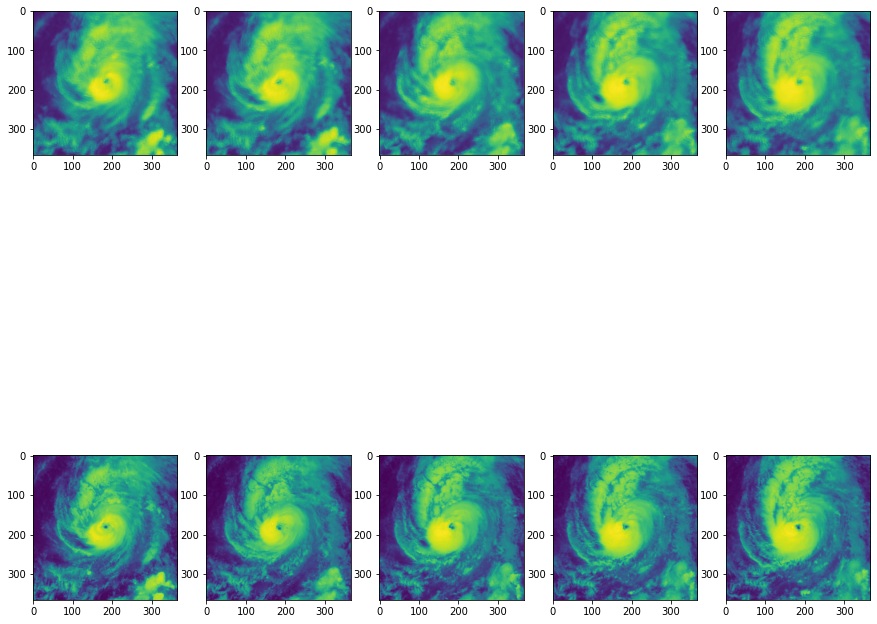

In [61]:
fig, axs = plt.subplots(2, 5, figsize=(15,15))

import matplotlib.pyplot as plt
to_PIL = transforms.ToPILImage()

for i in range(5): 
  axs[0, i].imshow(predics[i])
  axs[1, i].imshow(targets[i])

In [62]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from pathlib import Path
from PIL import Image
import numpy as np

def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

for i in range(5): 
  # Load target and predicted images for comparison
  predic = predics[i]*255.
  target = dataset[i+95]*255.

  # Scale predicted image to target range
  predic = scale2range(predic, [target.min(), target.max()])

  # Cast to uint8 to accommodate for consistent SSIM and MSE results
  target, predic = target.astype(np.uint8), predic.astype(np.uint8)

  # Sanity check
  print(target.dtype, target.max(), target.min())
  print(predic.dtype, predic.max(), predic.min())

  # Compute metrics
  s, m = ssim(target, predic), mse(target, predic)
  print('SSIM: ', s,'; MSE: ', m)

uint8 239 5
uint8 239 5
SSIM:  0.5374639508050209 ; MSE:  658.6039669742304
uint8 248 6
uint8 248 6
SSIM:  0.41502932091185113 ; MSE:  1263.29281256532
uint8 243 5
uint8 243 5
SSIM:  0.44452796362183855 ; MSE:  969.5368404550748
uint8 242 4
uint8 242 4
SSIM:  0.545462861564403 ; MSE:  625.8017110095852
uint8 243 4
uint8 243 4
SSIM:  0.544527403894559 ; MSE:  648.5392442294485
